### Optimal control of the ALN model
This notebook shows how to compute the optimal control (OC) signal for the ALN model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2


# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
model = ALNModel()
model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

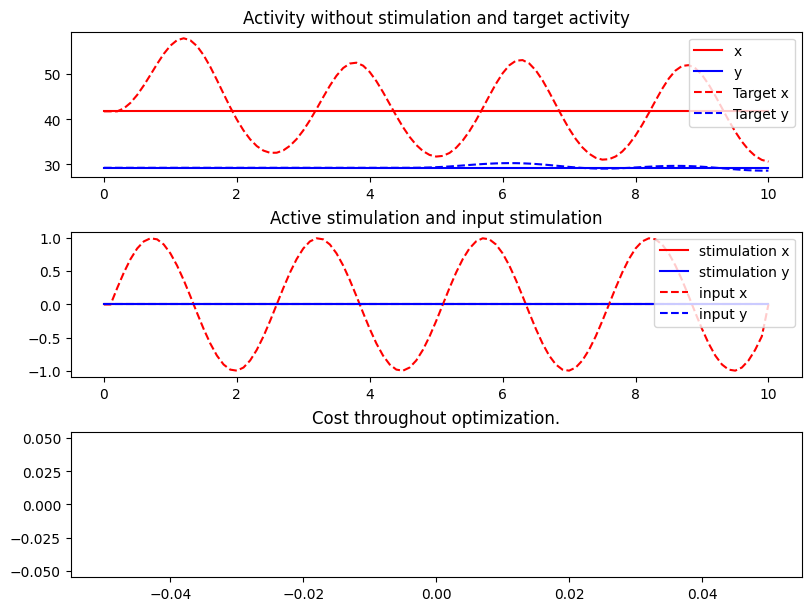

In [3]:
# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input
model.run()

# Define the result of the stimulation as target
target = getstate(model)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

In [4]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25))
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(1)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()

Compute control for a deterministic system
Cost in iteration 0: 321.04896146205573


AttributeError: 'OcAln' object has no attribute 'de_ndt'

Compute control for a deterministic system
Cost in iteration 0: 9.026323753171631e-05
Cost in iteration 25: 7.77444906912183e-05
Cost in iteration 50: 6.750590542946884e-05
Cost in iteration 75: 5.863437323791576e-05
Cost in iteration 100: 5.1244055125243176e-05
Final cost : 5.1244055125243176e-05


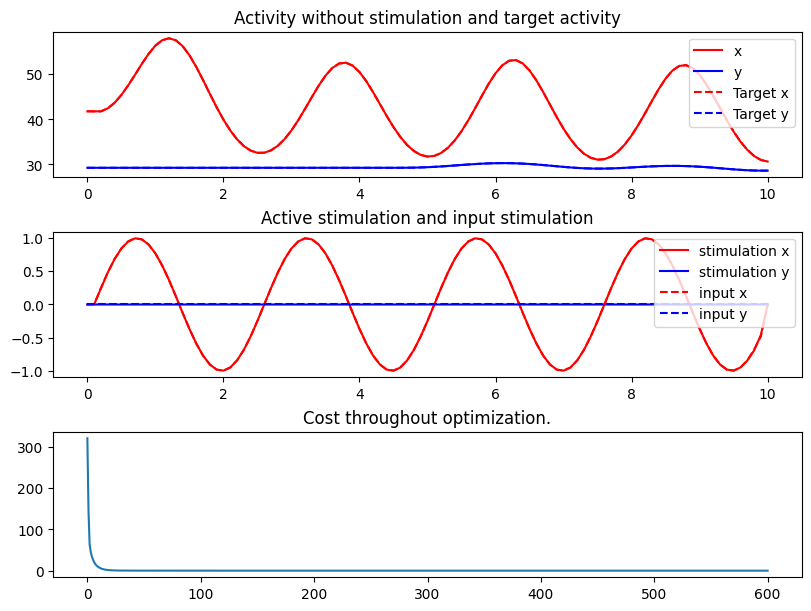

In [ ]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(1)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2


# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state


def set_param_init(model, a, b):
    # intermediate external input to membrane voltage to not reach the boundaries of the transfer function
    model.params.mue_ext_mean = 2.0
    model.params.mui_ext_mean = 0.5

    # no noise
    model.params.sigma_ou = 0.0

    # adaptation parameters
    model.params.a = a
    model.params.b = b
    model.params.tauA = 1.0

    for iv in model.init_vars:
        if "rates" in iv or "IA" in iv:
            model.params[iv] = np.zeros((model.params.N, model.getMaxDelay() + 1))
        else:
            model.params[iv] = np.zeros((model.params.N,))

    model.params.mue_ou = model.params.mue_ext_mean * np.ones((model.params.N,))
    model.params.mui_ou = model.params.mui_ext_mean * np.ones((model.params.N,))

    model.params["duration"] = max(1000, 2 * model.getMaxDelay())
    model.run()

    # initial state must not be random because delay computation requires history
    setinitstate(model, getfinalstate(model))
    if (
        model.params.rates_exc_init[0, -1] < 5
        or model.params.rates_inh_init[0, -1] < 5
        or model.params.rates_exc_init[0, -1] > 150
        or model.params.rates_inh_init[0, -1] > 150
    ):
        print("WARNING------------------------")
        print("Rates might be out of table range")
        print(model.params.rates_exc_init[0, -1], model.params.rates_inh_init[0, -1])

    return

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


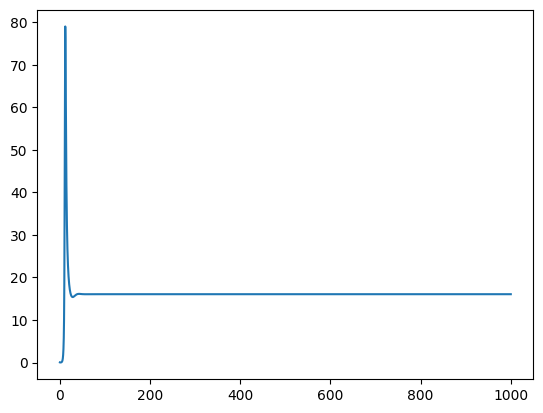

exc 0


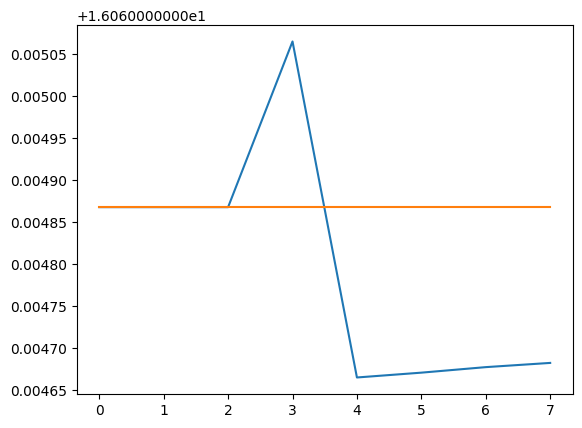

I 0


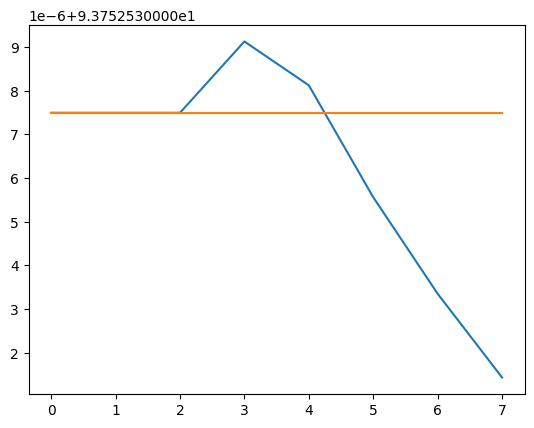

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.63277043e-06
  6.29233753e-07 -1.93312628e-06 -4.14271885e-06 -6.06050118e-06]


In [26]:
cmat = np.array( [[0., 0.], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = ALNModel(Cmat=cmat, Dmat=dmat)
model.params.de = 0.0
model.params.di = 0.0
set_param_init(model, 4., 40.)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

duration = 0.7
dt = model.params.dt

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
#input[0,1:-3] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.3, dt)/period) # other functions or random values can be used as well

amp = 1e-4
input[0,2] = 2 * amp
input[0,3] = - 4 * amp
#input[0,5] = 5 * amp

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
#plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

if True:
    print("exc 0")
    plt.plot(target[0,0,:])
    plt.plot(state[0,0,:])
    plt.show()

    print("I 0")
    plt.plot(target[0,2,:])
    plt.plot(state[0,2,:])
    plt.show()
    print(target[0,2,:]-state[0,2,:])

if False:
    print("exc 1")
    plt.plot(target[1,0,:])
    plt.plot(state[1,0,:])
    plt.show()

    print("I 1")
    plt.plot(target[1,2,:])
    plt.plot(state[1,2,:])
    plt.show()
    print(target[1,2,:]-state[1,2,:])

Compute control for a deterministic system
Cost in iteration 0: 9.495478403413929e-09
Cost in iteration 25: 3.32055084655939e-10
Cost in iteration 50: 4.504318043980729e-11
Cost in iteration 75: 6.695261621526306e-12
Cost in iteration 100: 8.930355417173972e-13
Final cost : 8.930355417173972e-13


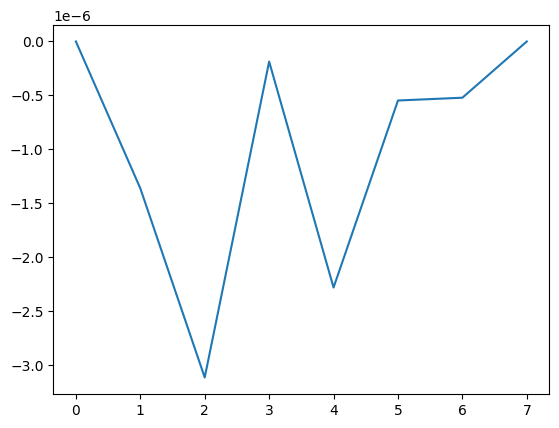

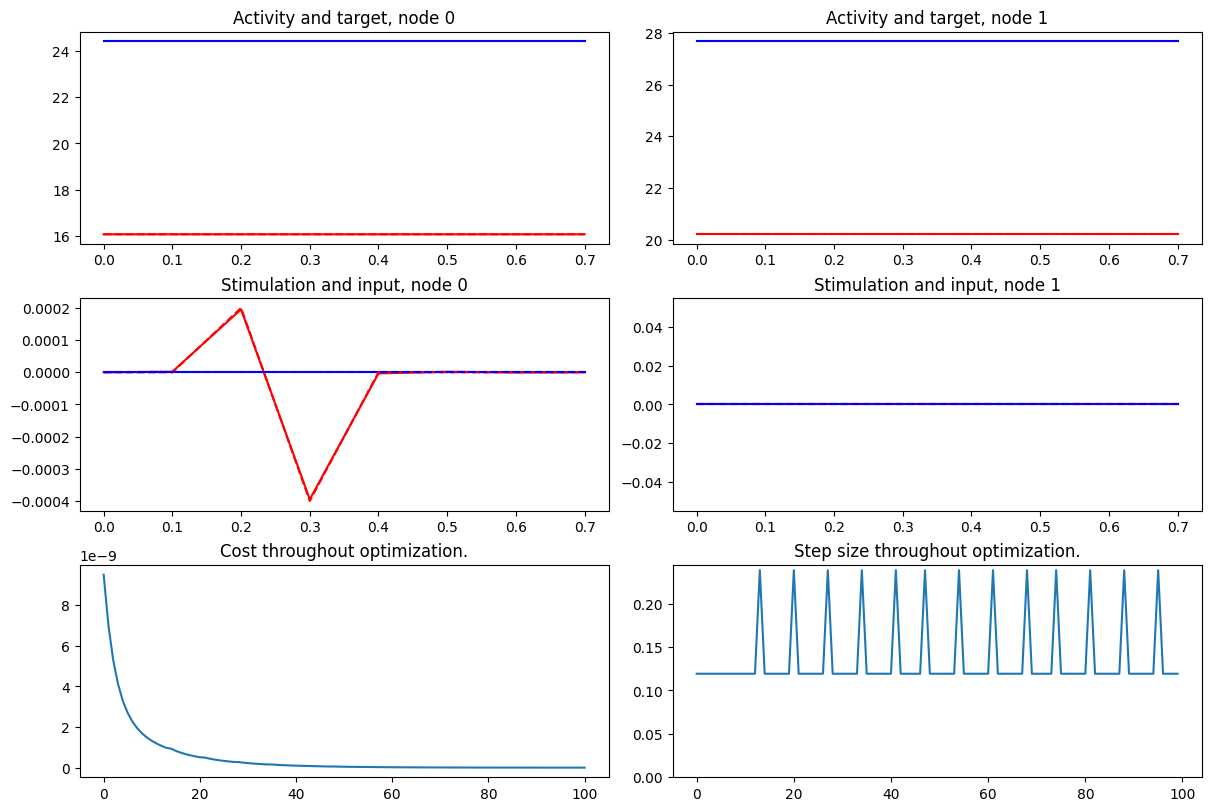

In [29]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[0,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)
model_controlled.step = 1e6

# We run 500 iterations of the optimal control gradient descent algorithm

model_controlled.optimize(100)

plt.plot(model_controlled.gradient[0,0,:])
plt.show()

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 8.930355417173972e-13
Cost in iteration 25: 1.3278598553272763e-13
Cost in iteration 50: 2.0528528315351913e-14
Cost in iteration 75: 3.001784601129336e-15
Cost in iteration 100: 4.588152025871244e-16
Cost in iteration 125: 7.146840424988906e-17
Cost in iteration 150: 1.1425264618911568e-17
Cost in iteration 175: 1.6993702465466068e-18
Cost in iteration 200: 2.6401487902971375e-19
Cost in iteration 225: 4.158105568088713e-20
Cost in iteration 250: 6.698947012111305e-21
Cost in iteration 275: 1.0009155530487358e-21
Cost in iteration 300: 1.5609686956671981e-22
Cost in iteration 325: 2.4622422609495424e-23
Cost in iteration 350: 3.995710489221606e-24
Cost in iteration 375: 5.953684712996779e-25
Cost in iteration 400: 9.060288377516784e-26
Cost in iteration 425: 1.473781497570103e-26
Cost in iteration 450: 2.177256098409993e-27
Converged in iteration 466 with cost 1.2451380528008451e-27
Final cost : 1.2451380528008451e-27


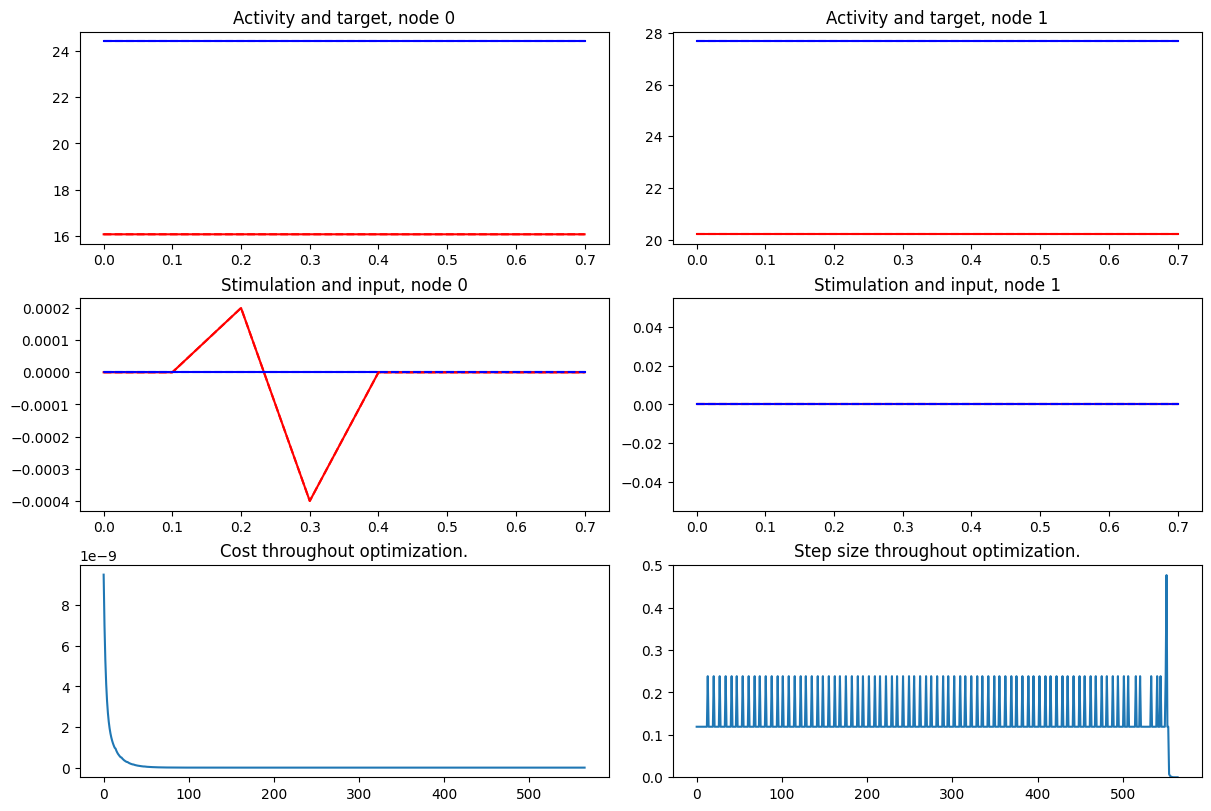

In [30]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(1000)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

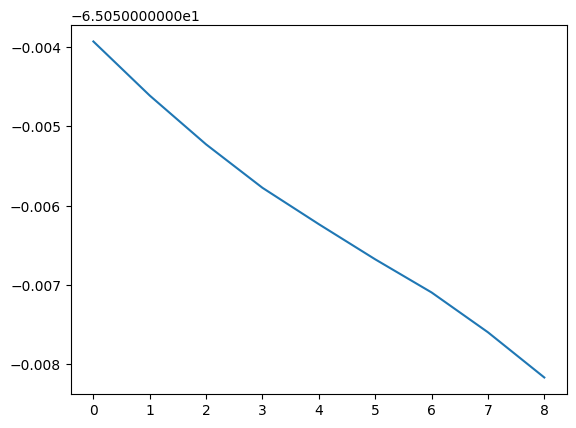

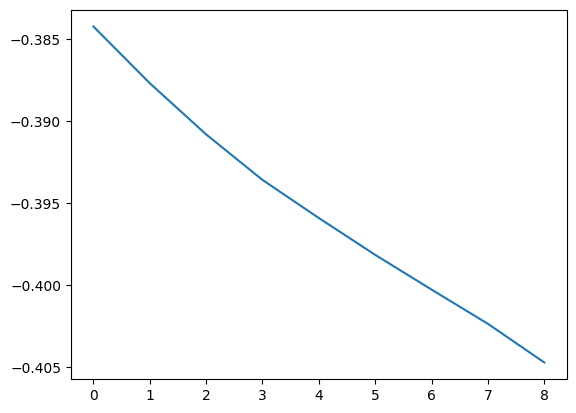

In [5]:
from neurolib.models.aln.timeIntegration import fast_interp2_opt, interpolate_values

Vtab = model.params.precalc_V

fullstate = model_controlled.get_fullstate()
mufe = fullstate[0,2,:]
sigmae = np.zeros((mufe.shape))
V = sigmae.copy()
V_dmu = V.copy()
V_ds = V.copy()

taum = model.params.C / model.params.gL

for t in range(len(sigmae)):

    z1ee_f = model.params.cee * model.params.Ke * model.params.tau_se / np.abs(model.params.Jee_max) * 1e-3
    z1ee = z1ee_f * fullstate[0,0,t]

    z1ei_f = model.params.cei * model.params.Ki * model.params.tau_si / np.abs(model.params.Jei_max) * 1e-3
    z1ei = z1ei_f * fullstate[0,1,t]

    sig_ee_factor = 2 * model.params.Jee_max**2 * model.params.tau_se * taum
    sig_ee_den = (1 + z1ee) * taum + model.params.tau_se

    sig_ei_factor = 2 * model.params.Jei_max**2 * model.params.tau_si * taum
    sig_ei_den = (1 + z1ei) * taum + model.params.tau_si

    sigmae[t] = np.sqrt(
        sig_ee_factor * fullstate[0,9,t] / sig_ee_den + sig_ei_factor * fullstate[0,10,t] / sig_ei_den + model.params.sigmae_ext**2
    )

    xid1, yid1, dxid, dyid = fast_interp2_opt(model.params.sigmarange, model.params.ds, sigmae[t], model.params.Irange, model.params.dI, 0.)
    xid1, yid1 = int(xid1), int(yid1)
    V[t] = interpolate_values(Vtab, xid1, yid1, dxid, dyid)

    xid1, yid1, dxid, dyid = fast_interp2_opt(model.params.sigmarange, model.params.ds, sigmae[t], model.params.Irange, model.params.dI, mufe[t] + model.params.dI)
    xid1, yid1 = int(xid1), int(yid1)
    Vdm = interpolate_values(Vtab, xid1, yid1, dxid, dyid)
    V_dmu[t] = (Vdm - V[t])/model.params.dI

    xid1, yid1, dxid, dyid = fast_interp2_opt(model.params.sigmarange, model.params.ds, sigmae[t] + model.params.ds, model.params.Irange, model.params.dI, 0.)
    xid1, yid1 = int(xid1), int(yid1)
    Vds = interpolate_values(Vtab, xid1, yid1, dxid, dyid)
    V_ds[t] = (Vds - V[t])/model.params.ds

plt.plot(V)
plt.show()

#plt.plot(V_dmu)
#plt.show()

plt.plot(V_ds)
plt.show()

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

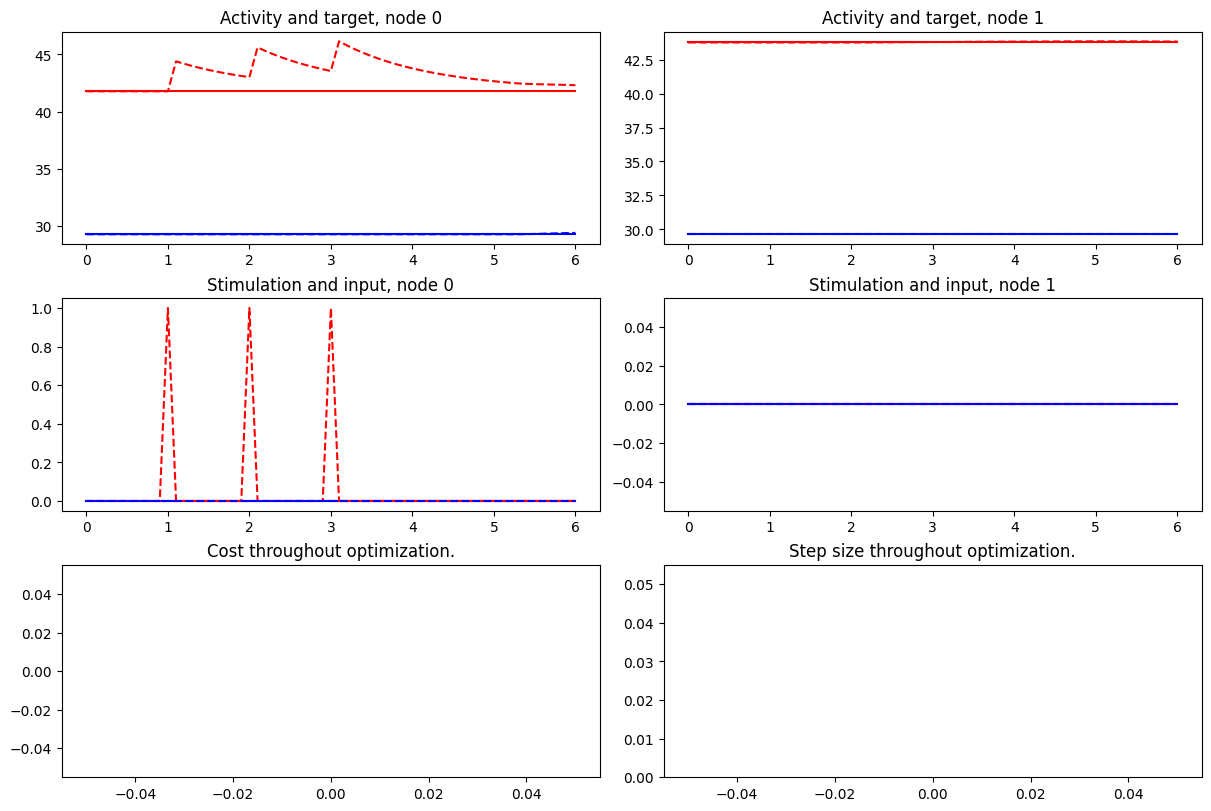

In [9]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

model = ALNModel(Cmat=cmat, Dmat=dmat)

model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

duration = 6.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,10] = 1. 
input[0,20] = 1.
input[0,30] = 1. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.0073807823328429474
Cost in iteration 25: 1.4291333523170422e-05
Cost in iteration 50: 1.0579171728784853e-05
Cost in iteration 75: 8.912972293496605e-06
Cost in iteration 100: 7.975481914364489e-06
Cost in iteration 125: 7.321087307684507e-06
Cost in iteration 150: 6.794239453914601e-06
Cost in iteration 175: 6.338403997205029e-06
Cost in iteration 200: 5.931208697526917e-06
Cost in iteration 225: 5.562149362131229e-06
Cost in iteration 250: 5.22542539569738e-06
Cost in iteration 275: 4.917042899134133e-06
Cost in iteration 300: 4.633816956453475e-06
Cost in iteration 325: 4.373033214301384e-06
Cost in iteration 350: 4.132547194765746e-06
Cost in iteration 375: 3.910294917477823e-06
Cost in iteration 400: 3.7046687767205892e-06
Cost in iteration 425: 3.514030238382178e-06
Cost in iteration 450: 3.3371418734979397e-06
Cost in iteration 475: 3.172686710073976e-06
Cost in iteration 500: 3.0196830911881864e-06
Final cost : 

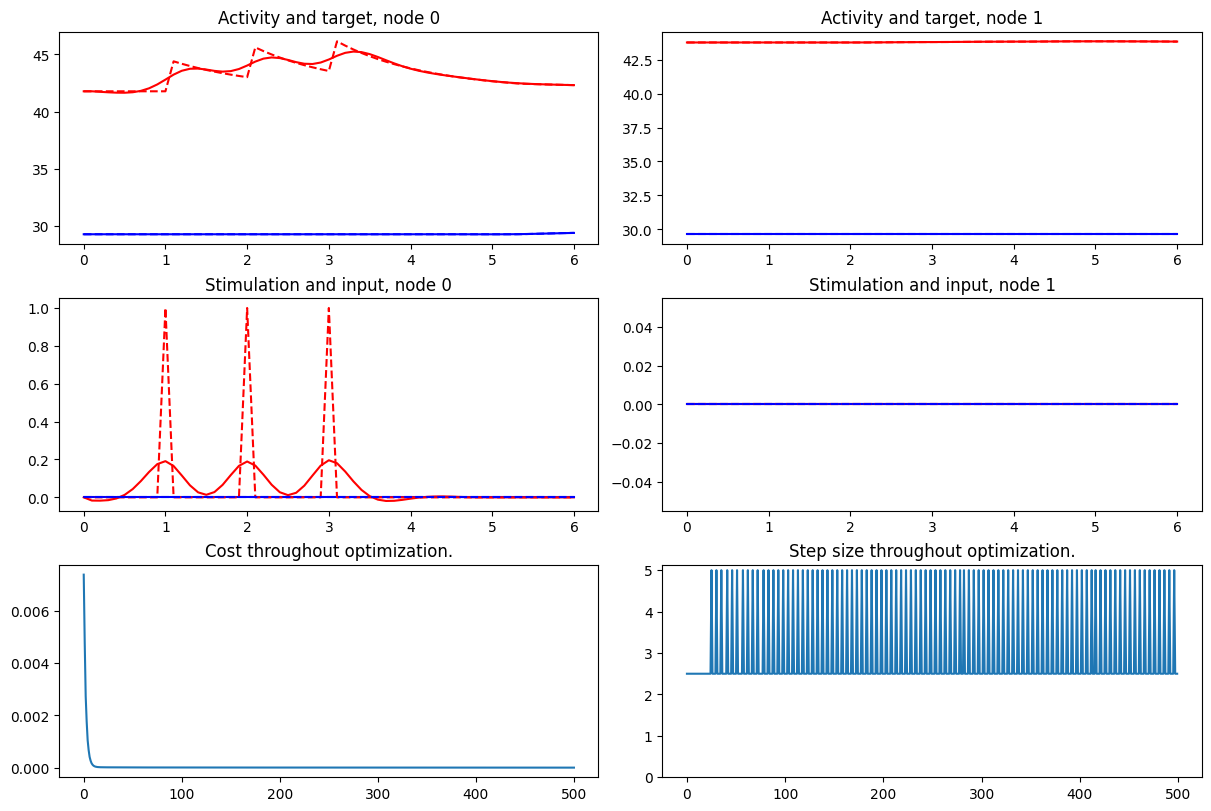

In [11]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 5.080966054037737e-07
Cost in iteration 25: 5.052648487182034e-07
Cost in iteration 50: 5.02497950535424e-07
Cost in iteration 75: 4.997956232504286e-07
Cost in iteration 100: 4.971529546825124e-07
Cost in iteration 125: 4.945696282797025e-07
Cost in iteration 150: 4.92041263487695e-07
Cost in iteration 175: 4.89567525234493e-07
Cost in iteration 200: 4.871433742725686e-07
Cost in iteration 225: 4.84769357028848e-07
Cost in iteration 250: 4.824421748967487e-07
Cost in iteration 275: 4.80161943737731e-07
Cost in iteration 300: 4.779250454632661e-07
Cost in iteration 325: 4.757315045103179e-07
Cost in iteration 350: 4.735781258158503e-07
Cost in iteration 375: 4.714648624970371e-07
Cost in iteration 400: 4.694564910494321e-07
Cost in iteration 425: 4.674032497169166e-07
Cost in iteration 450: 4.653853229565887e-07
Cost in iteration 475: 4.634048413567382e-07
Cost in iteration 500: 4.6145701195350823e-07
Final cost : 4.281266

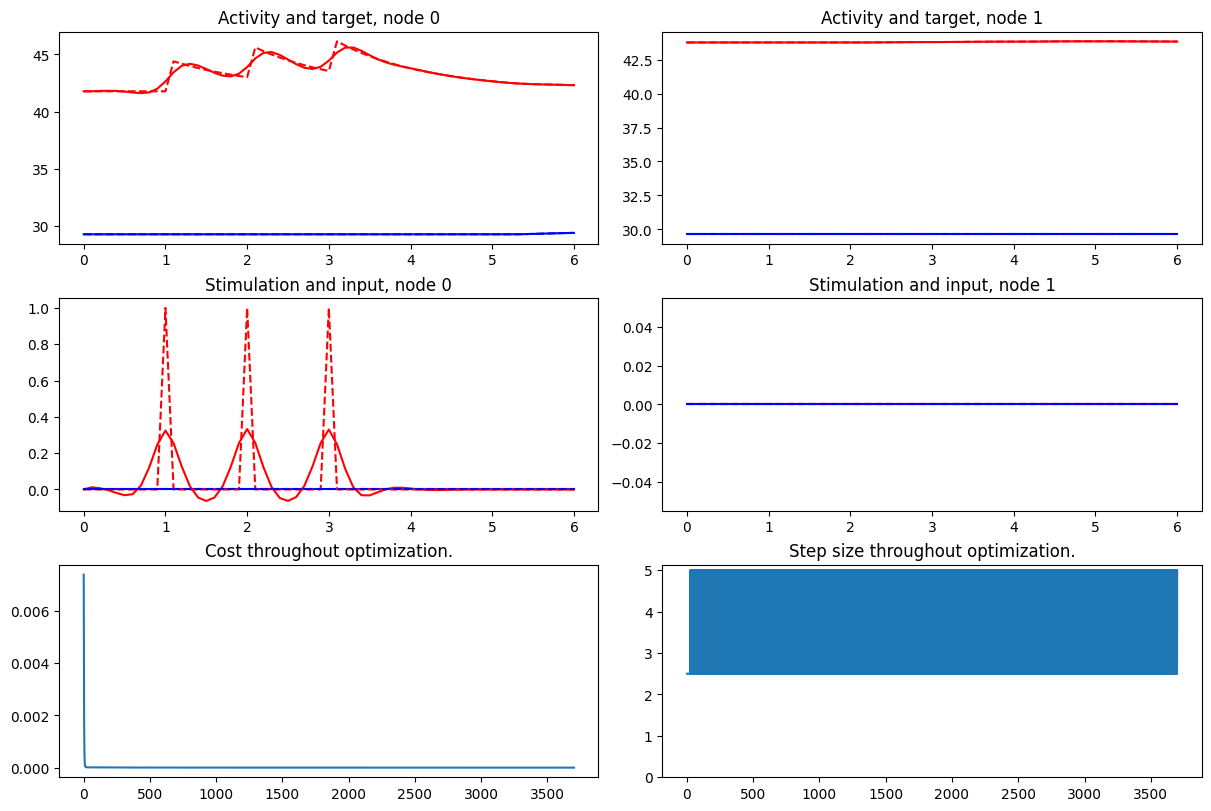

In [16]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 500 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)